# Implementing the PageRank Algorithm

This notebook implements the PageRank algorithm, an idea that is at the heart of Google's search algorithms.

In [1]:
import networkx as nx
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt

## Creating a Directed Graph

The following `create_graph` function builds and returns a directed graph, to be used later for executing the PageRank algorithm. The graph may either be created from a user-provided CSV file, or it may be generated randomly.

In [2]:
def create_graph(graph_file=None, num_nodes=10, p=0.35):
    """
    Creates and returns a directed graph.
    
    If the path to a CSV file containing details about edges for the directed graph is provided as the
    'graph_file' argument, the corresponding directed graph is created. Otherwise, a random directed graph is
    generated with 'num_nodes' nodes in which each edge is included with a probability of 'p'.
    
    Parameters
    ----------
    graph_file : str
        The path to a CSV file with any number of rows, each row of the form 'P1,P2', indicating the presence
        of a directed edge from node P1 to node P2. Default value is None. Note that this function treats every
        node name as a string.
    num_nodes : int
        The number of nodes to be included in the randomly generated directed graph, considered if and only if
        graph_file=None. Default value is 10.
    p : float
        The probability (between 0 and 1) with which each directed edge is included in the randomly generated
        directed graph, considered if and only if graph_file=None. Default value is 0.35.
        
    Returns
    -------
    networkx.classes.digraph.DiGraph object
        A directed graph
    """
    G = nx.DiGraph()
    
    if graph_file is None:
        G = nx.gnp_random_graph(num_nodes, p, directed=True)
        
    else:
        with open(graph_file, 'r') as f:
            lines = f.read().splitlines()
        for line in lines:
            nodes = [i.strip() for i in line.split(',')]
            if len(nodes) != 2:
                raise Exception("The length of each row in the CSV file must be exactly 2.")
            G.add_nodes_from(nodes)
            G.add_edge(nodes[0], nodes[1])
                
    return G

Let us now create a graph using this function, and visualize it.

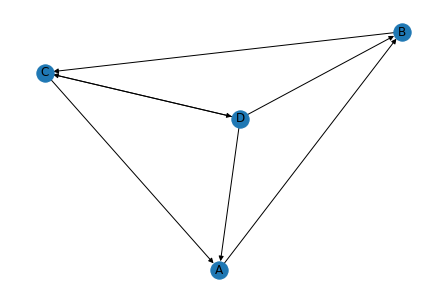

In [3]:
G = create_graph('pagesData.csv')
nx.draw(G, with_labels=True)
plt.show()

## PageRank Calculation using Power Iteration

The following function `pagerank_power_iteration` calculates the PageRanks of all pages involved using the power iteration method. This method is very accurate and speed is optimized by using NumPy. (This runs quite a bit faster than the random walk simulation method later below.)

In [4]:
def pagerank_power_iteration(digraph, max_iters=1000000, damping_factor=0.85):
    """
    Uses the power iteration method to determine and return a list of tuples of the form
    (node name, PageRank of node, relative rank of node), sorted in decreasing order of PageRank.
    
    Parameters
    ----------
    digraph : networkx.classes.digraph.DiGraph object
        A directed graph, in which PageRanks of nodes are to be calculated.
    max_iters : int
        The maximum number of power iterations to be used in the algorithm. Default value is 1,000,000.
    damping_factor : float
        The probability (between 0 and 1), at any step, of the user jumping from a node to a random node in
        the directed graph instead of moving to a neighbor node. Default value is 0.85.
        
    Returns
    -------
    list
        A list of tuples of the form (node name, PageRank of node, relative rank of node), sorted in decreasing
        order of PageRank.
    """
    nodes_list = list(digraph)
    num_nodes = len(nodes_list)
    
    L1 = np.zeros((num_nodes, num_nodes))
    
    for x, n1 in enumerate(nodes_list):
        if digraph.out_degree(n1) == 0:
            for y in range(num_nodes):
                L1[y, x] = 1/num_nodes
        else:
            for y, n2 in enumerate(nodes_list):
                if digraph.has_edge(n1, n2):
                    L1[y, x] = 1/digraph.out_degree(n1)
                    
    L2 = np.full((num_nodes, num_nodes), 1/num_nodes)
    
    L = damping_factor*L1 + (1-damping_factor)*L2
    
    r = np.full((num_nodes, 1), 1/num_nodes)
    
    for i in range(max_iters):
        prev_r = r
        r = np.dot(L, r)
        if (r == prev_r).all():
            break
    
    tmp = {}
    
    for i, node in enumerate(nodes_list):
        tmp[node] = r[i, 0]
        
    tmp = sorted(tmp.items(), key = lambda x: (x[1], x[0]))
    
    pr_list = []
    
    for i, pair in enumerate(tmp[::-1]):
        pr_list.append((pair[0], pair[1], i+1))
        
    return pr_list

In [5]:
print(pagerank_power_iteration(G, damping_factor=0.85))

[('C', 0.3231019549313691, 1), ('B', 0.27772952297064724, 2), ('A', 0.22435019125215086, 3), ('D', 0.17481833084583184, 4)]


## PageRank Calculation using a Random Walk Simulation

The following function `pagerank_random_walk` computes the PageRanks of all involved pages using a more empirical technique, i.e., a random walk simulation. By simulating the movements of a user among the pages, we estimate the PageRank of each page as the fraction of total time that the user spends on that page.

In [6]:
def pagerank_random_walk(digraph, num_iters=1000000, damping_factor = 0.85):
    """
    Uses the random walk method to determine and return a list of tuples of the form
    (node name, PageRank of node, relative rank of node), sorted in decreasing order of PageRank.
    
    Parameters
    ----------
    digraph : networkx.classes.digraph.DiGraph object
        A directed graph, in which PageRanks of nodes are to be calculated.
    num_iters : int
        The number of iterations (random walk movements) in the algorithm. Default value is 1,000,000.
    damping_factor : float
        The probability (between 0 and 1), at any random walk step, of a user jumping to a random node in the
        graph instead of moving to a neighbor node. Default value is 0.85.
    
    Returns
    -------
    list
        A list of tuples of the form (node name, PageRank of node, relative rank of node), sorted in decreasing
        order of PageRank.
    """
    dict_counts = {}
    
    for node in list(digraph):
        dict_counts[node] = 0
        
    current_node = random.choice(list(digraph))
    
    for i in range(num_iters):
        dict_counts[current_node] += 1
        neighbors = list(digraph.neighbors(current_node))
        random_jump = np.random.choice([True, False], p=[1.0-damping_factor, damping_factor])
        if len(neighbors) == 0 or random_jump:
            current_node = random.choice(list(digraph))
        else:
            current_node = random.choice(neighbors)
            
    for k in dict_counts.keys():
        dict_counts[k] /= num_iters
        
    tmp = sorted(dict_counts.items(), key = lambda x: (x[1], x[0]))
    
    pr_list = []
    
    for i, pair in enumerate(tmp[::-1]):
        pr_list.append((pair[0], pair[1], i+1))
        
    return pr_list

In [7]:
print(pagerank_random_walk(G))

[('C', 0.322981, 1), ('B', 0.278031, 2), ('A', 0.224486, 3), ('D', 0.174502, 4)]


## Comparison

Python's NetworkX package also has an inbuilt function `pagerank` to calculate PageRanks of pages. Let's see how our results from above compare with the results of the `pagerank` function.

In [8]:
pr_dict = nx.pagerank(G)

tmp = sorted(pr_dict.items(), key = lambda x : (x[1], x[0]))

pr_list = []
    
for i, pair in enumerate(tmp[::-1]):
    pr_list.append((pair[0], pair[1], i+1))

pr_list

[('C', 0.3231025807001189, 1),
 ('B', 0.27772997055023435, 2),
 ('A', 0.22434968170057584, 3),
 ('D', 0.1748177670490708, 4)]

Well, the results are close enough! :)